In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Geodesics as gd
import Model as md
import cmath as cmt
import glob
import os
import time
from scipy.optimize import curve_fit as cf
from Functions import *

## Monte Carlo Simulation at zero temperature

In [ ]:
for nlayers in range(4,5):
    #Set up model
    p = 5; q = 4
    start = time.time()
    print("Defining model with " + str(nlayers) + " layers", end = '\r')
    model = md.FractonModel(p,q,nlayers, kernel = 'SRG')
    end = time.time()
    elapsed = end-start
    nSpins = len(model.lattice)
    nGeods = len(model.geodesicList)
    print("Finished defining model with " + str(nlayers) + " layers. It took: " + str(round(elapsed,2)) + ' s'+' There are '+str(nSpins)+ ' sites and '+str(nGeods) + ' geodesics' +' '*100)
    #Lattice parameters
    nDecorr = 10 #Steps to decorrelate  
    nMeasurements = nGeods*250 #Number of measurements
    saveFreq = 1000 #Save frequency
    
    # Define the directory where you want to save the files
    save_dir = "../Data/P"+str(p)+"Q"+str(q)+"/"+str(nlayers)+"Layers"
    timeSeries_dir = save_dir+'/Correlations'
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        os.makedirs(timeSeries_dir)

    #Number of spins in the border
    nBorder = len(model.border)
    distances = np.linspace(1,int(nBorder/2), int(nBorder/2))

    #Initialize correlation and states arrays
    corr = np.zeros(int(len(model.border)/2))
    corrTimeSeries = np.zeros((saveFreq,int(len(model.border)/2)))
    
    
    #Initialize save counter
    saveCounter = 0
    elapsed = 0
    freq = 1
    if nlayers > 5:
        freq = 10
    

    ##EntanglementEntropy
    start = time.time()
    ent_entr = entanglement_entropy(model,freq = freq)
    end = time.time()
    print('Entropy took: ' + str(round(end-start,2)) + ' s' + ' '*1000, end = '\n')
    borderCenters = model.centers[model.border]
    blockSizes = np.linspace(1,nBorder,nBorder)
    np.save(os.path.join(save_dir, "EntanglEntr.npy"),ent_entr)
    figEntr,axEntr = plt.subplots()
    axEntr.set_title("Entropy Layers = " + str(nlayers))
    axEntr.plot(blockSizes,ent_entr)
    axEntr.set_ylabel(r'$E_l$')
    axEntr.set_xlabel(r'$l$')
    axEntr.set_xscale('log')
    figEntr.savefig(os.path.join(save_dir, "EntanglEntr.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)

    #Simulation main loop

    for iteration in range(nMeasurements):
        start = time.time()
        model.decorrelate(nDecorr)
        temp = np.array(model.getBorderCorrelations()/nBorder)
        corrTimeSeries[saveCounter,:] = temp/nMeasurements
        corr += temp/nMeasurements
        saveCounter += 1
        end = time.time()
        elapsed += end - start
        if(saveCounter == saveFreq):
            print('Computing correlation. \tPercentage: ' + str(round(iteration/nMeasurements*100)) + '% \t' + str(round(iteration/elapsed)) + ' it/s' + '\t Time remaining: ' + str(round((elapsed*(nMeasurements-iteration)/iteration)/60,2)) +' min     ', end = '\r')
            np.save(os.path.join(save_dir, "Correlation" + ".npy"),np.array(corr))
            np.save(os.path.join(timeSeries_dir, "CorrelationTimeSeries"+str(int(iteration/saveFreq)) + ".npy"),np.array(corrTimeSeries))
            saveCounter = 0
    print('Correlation took: ' + str(round(elapsed,2))+' s'+' '*1000, end = '\n')

    figCorr, axCorr = plt.subplots()
    axCorr.set_title("Correlation Layers = " + str(nlayers))
    axCorr.plot(distances,corr/nMeasurements)
    axCorr.set_ylabel(r'$\left< e_ne_{n+d} \right>$')
    axCorr.set_xlabel(r'$d$')
    figCorr.savefig(os.path.join(save_dir, "CorrelationFigure.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)


    gedsPerLength = geodesicsePerLength(model)
    np.save(os.path.join(save_dir, "NumGeods.npy"),geodesicsePerLength)

## Monte Carlo at finite beta

In [2]:
def generateBonds(spins, interaction, beta):
    bondsList = np.zeros(len(interaction))
    for idx,link in enumerate(interaction):
        prod =1
        for s in link:
            prod *= spins[s]
        prob = 1-np.exp(-beta*prod-beta)
        rand = np.random.uniform()
        if rand<prob:
            bondsList[idx] = 1
    return bondsList

def generateClusters(spins, bondsList, linksList, interaction):
    nSpins = len(spins)
    availableSpins = [i for i in range(nSpins)]
    clusters = []
    while nSpins!=0:
        seed = availableSpins[0]
        currentClusterTemp = [seed]
        currentCluster = [seed]
        availableSpins.remove(seed)
        while currentClusterTemp != []:
            site = currentClusterTemp[0]
            for l in linksList[site]:
                if bondsList[l] ==1:
                    for s in interaction[l]:
                        if s not in currentCluster:
                            currentCluster.append(s)
                            currentClusterTemp.append(s)
                            if s in availableSpins:
                                availableSpins.remove(s)
            currentClusterTemp.remove(site)
        nSpins -= len(currentCluster)
        clusters.append(currentCluster)
    return clusters

In [13]:
model  = md.FractonModel(5,4,6)
beta_list = 1/np.linspace(0.0,2.0,10)
print(1/beta_list[1:])

[0.22222222 0.44444444 0.66666667 0.88888889 1.11111111 1.33333333
 1.55555556 1.77777778 2.        ]


/tmp/ipykernel_50573/4078838545.py:2: RuntimeWarning: divide by zero encountered in divide
  beta_list = 1/np.linspace(0.0,2.0,10)


In [14]:
print(len(model.border))

2090


In [5]:
numSteps = 50000
energies = np.zeros(len(beta_list[1:]))
cv = np.zeros(len(beta_list[1:]))
correlations = np.zeros((int(len(model.border)/2),len(beta_list[1:])))
for idx,beta in enumerate(beta_list[1:]):
    enList = np.zeros(numSteps)
    corrList = np.zeros((int(len(model.border)/2),numSteps))
    print(beta)
    for step in range(numSteps):
        start = time.time()
        model.decorrelate(5)
        for waitStep in range(2):
            bonds = generateBonds(model.spins,model.interactions,beta)
            clusters = generateClusters(model.spins,bonds,model.linksList, model.interactions)
            for cl in clusters:
                model.spins[cl] = model.spins[cl]*(np.random.randint(0,2)*2-1)
        enList[step] = model.hamiltonian()/len(model.lattice)
        corrList[:,step] = model.getBorderCorrelations()
        end = time.time()
        print('step = '+str(step)+' time per step = ' + str(end-start)+' '*100,end = '\r') 
    energies[idx] = np.mean(enList)
    cv[idx] = np.var(enList)*beta*beta
    correlations[:,idx] = np.mean(corrList[:,500:], axis = 1)

np.save("./cv6.npy",cv)
np.save("./energy6.npy",energies)
np.save("./correlations6.npy",correlations)
np.save("./betas6.npy",np.array(beta_list[1:]))

4.5
2.25 = 49999 time per step = 0.43549084663391113                                                                                                    
1.5p = 49999 time per step = 0.4259672164916992                                                                                                     
1.125= 49999 time per step = 0.4078710079193115                                                                                                     
0.8999999999999999per step = 0.37378454208374023                                                                                                    
0.75 = 49999 time per step = 0.352053165435791                                                                                                      
0.6428571428571429per step = 0.23315739631652832                                                                                                    
0.5625 49999 time per step = 0.22389793395996094                                                      

In [15]:
beta_list6 = np.load("./betas6.npy")
energies6 = np.load("./energy6.npy")
correlations6 = np.load("./correlations6.npy")
cv6 = np.load("./cv6.npy")

beta_list = np.load("./betas.npy")
energies = np.load("./energy.npy")
correlations = np.load("./correlations.npy")
print(1/beta_list)
print(1/beta_list6)

[0.08 0.16 0.24 0.32 0.4  0.48 0.56 0.64 0.72 0.8  0.88 0.96 1.04 1.12
 1.2  1.28 1.36 1.44 1.52 1.6  1.68 1.76 1.84 1.92 2.  ]
[0.22222222 0.44444444 0.66666667 0.88888889 1.11111111 1.33333333
 1.55555556 1.77777778 2.        ]


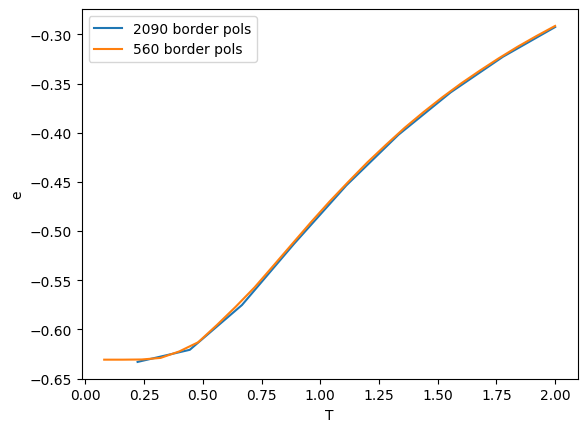

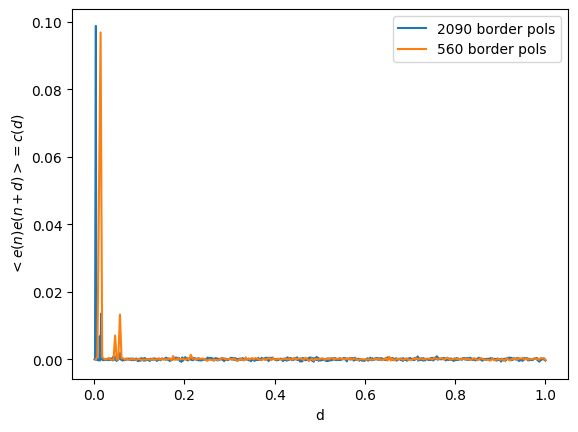

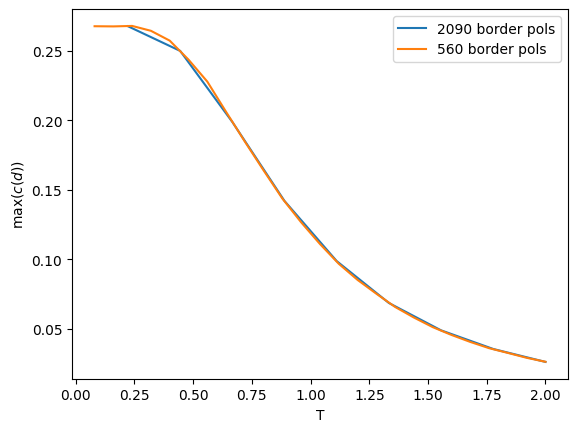

In [16]:
sixLabel = "2090 border pols"
fiveLabel = '560 border pols'

distances6 = np.linspace(1,1045, 1045)/1045
distances = np.linspace(1,280,280)/280

##Energy

plt.plot(1/beta_list6,energies6,label = sixLabel)
plt.plot(1/beta_list,energies,label = fiveLabel)
plt.xlabel("T")
plt.ylabel("e")
plt.legend()
plt.show()
plt.savefig("./Energy.png")

##Correlations
plt.plot(distances6,correlations6[:,4]/2090,label = sixLabel)
plt.plot(distances,correlations[:,13]/560,label = fiveLabel)
plt.xlabel("d")
plt.ylabel(r"$<e(n)e(n+d)>=c(d)$")
plt.legend()
plt.savefig("./Corrs.png")
plt.show()

##CorrelationsHeights
heights6 = [correlations6[3,n]/2090 for n in range(9)]
heights = [correlations[3,n]/560 for n in range(25)]
plt.plot(1/beta_list6,heights6,label = sixLabel)
plt.plot(1/beta_list,heights,label = fiveLabel)
plt.xlabel("T")
plt.ylabel(r"$\text{max}(c(d))$")
plt.legend()
plt.savefig("./CorrHeights.png")
plt.show()


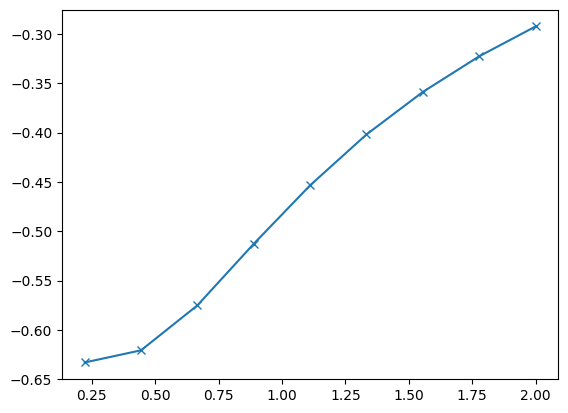

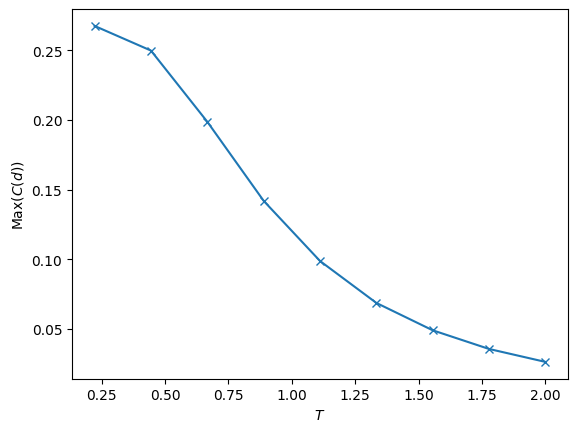

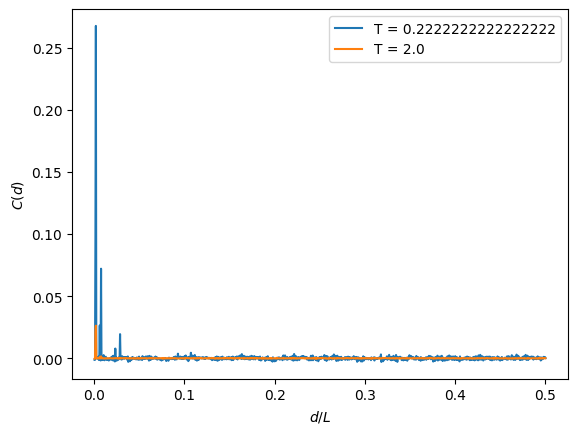

In [12]:
plt.plot(1/beta_list[1:],energies, 'x-')
plt.show()
heights = [correlations[3,n]/len(model.border) for n in range(9)]
plt.plot(1/beta_list[1:],np.array(heights),'x-')
plt.xlabel('$T$')
plt.ylabel(r'$\text{Max}(C(d))$')
plt.savefig("./CorrelationHeight.png")
plt.show()

distances = np.linspace(1,len(model.border)/2, int(len(model.border)/2))/int(len(model.border))

plt.plot(distances, correlations[:,0]/len(model.border), label = 'T = '+str(1/beta_list[1]))
plt.plot(distances, correlations[:,8]/len(model.border), label = 'T = '+str(1/beta_list[9]))
plt.xlabel(r'$d/L$')
plt.ylabel(r'$C(d)$')
plt.legend()
plt.savefig("./CorrelationsTemps.png")


## Entanglement entropy with BH

In [74]:
model = md.FractonModel(5,4,5, kernel = 'SRG')
insidePols = insidePolygons(model)
print(sorted(list(set([np.round(g.distanceToOrigin+0.0001,4) for g in model.geodesicList]))))
bHoleRads = [0.01,0.3037, 0.7076, 0.8198, 0.8893, 0.9036, 0.9202, 0.9377, 0.9452, 0.9605, 0.9663]

[0.3037, 0.7076, 0.8198, 0.8893, 0.9036, 0.9202, 0.9377, 0.9451, 0.9604, 0.9662, 0.9677, 0.9698, 0.9727, 0.9742, 0.9764, 0.9782, 0.9814, 0.9819, 0.9826, 0.9841, 0.9845, 0.9868, 0.9872, 0.9886, 0.9897, 0.9915, 0.9921]


In [75]:
borderSize = int(len(model.border))
halfBorderSize = int(len(model.border)/2)
borderPolygons = model.border
entropy = np.zeros((len(bHoleRads),borderSize-1))

step = 1
numStatistics = int(borderSize/step)

for radIdx,rad in enumerate(bHoleRads):
    for size in range(2,halfBorderSize+2):
        sizeBorder = size-1
        complementSize = borderSize-sizeBorder
        startTime = time.time()
        for start in range(numStatistics):
            first = step*start
            last = (step*start+size-1)%borderSize
            for g in range(len(model.geodesicList)):
                if model.geodesicList[g].distanceToOrigin > rad:
                    wedgeGeod = insidePols[g]
                    x = wedgeGeod[first] == -1
                    y = wedgeGeod[last] == -1
                    if bool((x and not y) or (y and not x)):
                        entropy[radIdx,sizeBorder-1] += 1
                        entropy[radIdx,complementSize-1]+=1
                else:
                    wedgeGeod = insidePols[g]
                    x = wedgeGeod[first] == -1
                    y = wedgeGeod[last] == -1
                    if bool((x and not y) or (y and not x)):
                        entropy[radIdx,sizeBorder-1] += 1
                        entropy[radIdx,complementSize-1]+=1
                    elif bool(x and y):
                        entropy[radIdx,complementSize-1] += 2
                    else:
                        test = [wedgeGeod[(first +index)%borderSize] for 
                        index in range(size) ]
                        if np.sum(test)!=size:
                            entropy[radIdx,sizeBorder-1] += 2
                        else:
                            entropy[radIdx,complementSize-1] += 2
        end = time.time()
        elapsed = end-startTime
        message = f'Time remaining: {round(elapsed*(halfBorderSize+1-size)/60,2):.2f} m'
        print(message, end = '\r')
    print(f'Finished black hole with radius {rad:.4f}',end = '\n')
entropy[:,int((borderSize-1)/2)] = entropy[:,int((borderSize-1)/2)]/2 
entropy = entropy/numStatistics
blockSizes = np.linspace(1,borderSize-1,borderSize-1)
np.save("./entropyTest.py",entropy)

Finished black hole with radius 0.0100
Finished black hole with radius 0.3037
Finished black hole with radius 0.7076
Finished black hole with radius 0.8198
Finished black hole with radius 0.8893
Finished black hole with radius 0.9036
Finished black hole with radius 0.9202
Finished black hole with radius 0.9377
Finished black hole with radius 0.9452
Finished black hole with radius 0.9605
Finished black hole with radius 0.9663


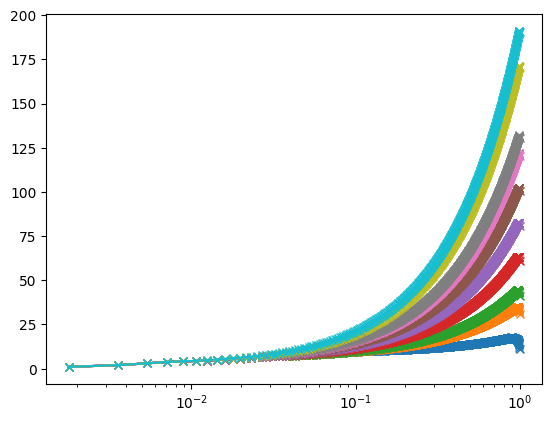

In [80]:
blockSizes = np.linspace(1,borderSize-1,borderSize-1)
blockSizes = blockSizes/borderSize
for n in range(1,11):
    plt.plot(blockSizes[blockSizes<1],entropy[n,blockSizes<1],'x-')
plt.xscale('log')

In [81]:
borderSize = int(len(model.border))
halfBorderSize = int(len(model.border)/2)
borderPolygons = model.border
#entropy = np.load("./entropy.npy")
blockSizes = np.linspace(1,borderSize-1,borderSize-1)/borderSize

/tmp/ipykernel_95195/2326810377.py:3: RuntimeWarning: invalid value encountered in log
  return (c/3)*np.log(1.0/(np.pi*a)*np.sin(np.pi*l))


[6.78450237e+00 1.51957645e-03]


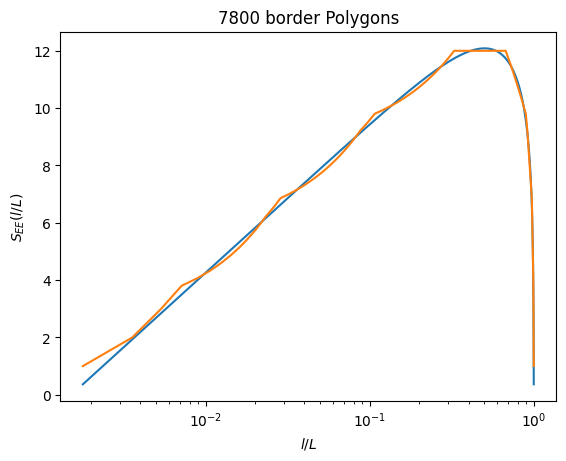

In [82]:
## Functions
def entropyZero(l,c,a):
    return (c/3)*np.log(1.0/(np.pi*a)*np.sin(np.pi*l))

parametersZero, covarianceZero = cf(entropyZero,blockSizes,entropy[0,:])
print(parametersZero)
plt.plot(blockSizes,entropyZero(blockSizes,*parametersZero))
plt.plot(blockSizes,entropy[0])
plt.xscale('log')
plt.xlabel(r'$l/L$')
plt.ylabel(r'$S_{EE}(l/L)$')
plt.title("7800 border Polygons")
#plt.savefig("./EntanglementEntropyAtZeroT.png")


def entropyFiniteBeta(l,beta):
    return (parametersZero[0]/3)*np.log((beta/(np.pi*parametersZero[1])*np.sinh(l*np.pi/beta)))



8.924968814496786e-05
1.0145491387348587e-07
5.475903901192418e-08
3.4509146981466355e-09
7.864008912275018e-10
4.209798853100651e-10
3.384951804391433e-10
2.821892520998449e-10
9.424415434233722e-11
4.365310914456778e-11


/tmp/ipykernel_95195/2326810377.py:17: RuntimeWarning: overflow encountered in sinh
  return (parametersZero[0]/3)*np.log((beta/(np.pi*parametersZero[1])*np.sinh(l*np.pi/beta)))


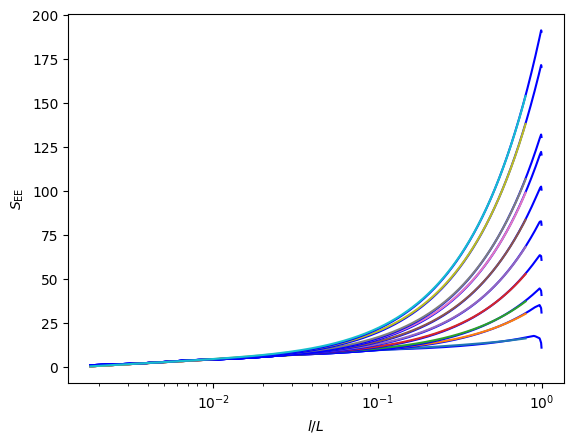

In [84]:
smallL = blockSizes <0.8
betas = []
beta_Var = []
for index in range(1,11):
    plt.plot(blockSizes,entropy[index,:], label = 'Numerical BH radius = ' + str(round(bHoleRads[index],4)),color = 'blue')
    parameters, variance = cf(entropyFiniteBeta,blockSizes[smallL],entropy[index,smallL])
    print(variance[0,0])
    betas.append(np.abs(parameters[0]))
    beta_Var.append(np.sqrt(variance[0,0]))
    plt.plot(blockSizes[smallL],entropyFiniteBeta(blockSizes[smallL],*parameters), label = 'Calabrese-Cardy')
plt.ylabel(r'$S_{\text{EE}}$')
plt.xlabel(r'$l/L$')
plt.xscale('log')
#plt.legend()
#plt.savefig("./EntanglementEntropies.png")

[9.44720531e-03 3.18519880e-04 2.34006494e-04 5.87444865e-05
 2.80428403e-05 2.05177944e-05 1.83982385e-05 1.67984896e-05
 9.70794285e-06 6.60704996e-06]


Text(0.5, 0, 'Black hole hyperbolic radius')

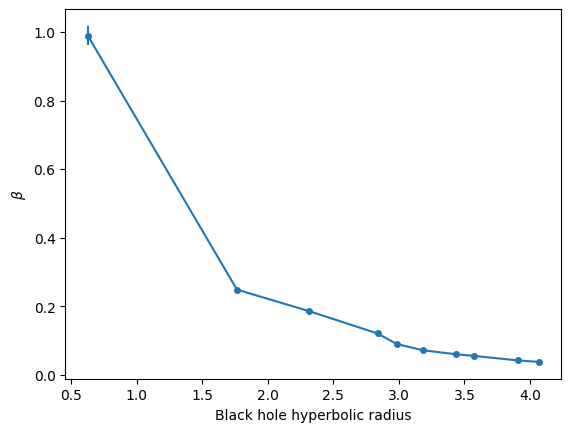

In [116]:
print(np.array(beta_Var))
plt.errorbar(np.log((1+np.array(bHoleRads[1:]))/((1-np.array(bHoleRads[1:])))),np.array(betas), yerr = 3*np.array(beta_Var),marker = 'o', markersize = 4)
plt.ylabel(r'$\beta$')
plt.xlabel(r'Black hole hyperbolic radius')

(<Figure size 1200x1050 with 1 Axes>, <Axes: >)

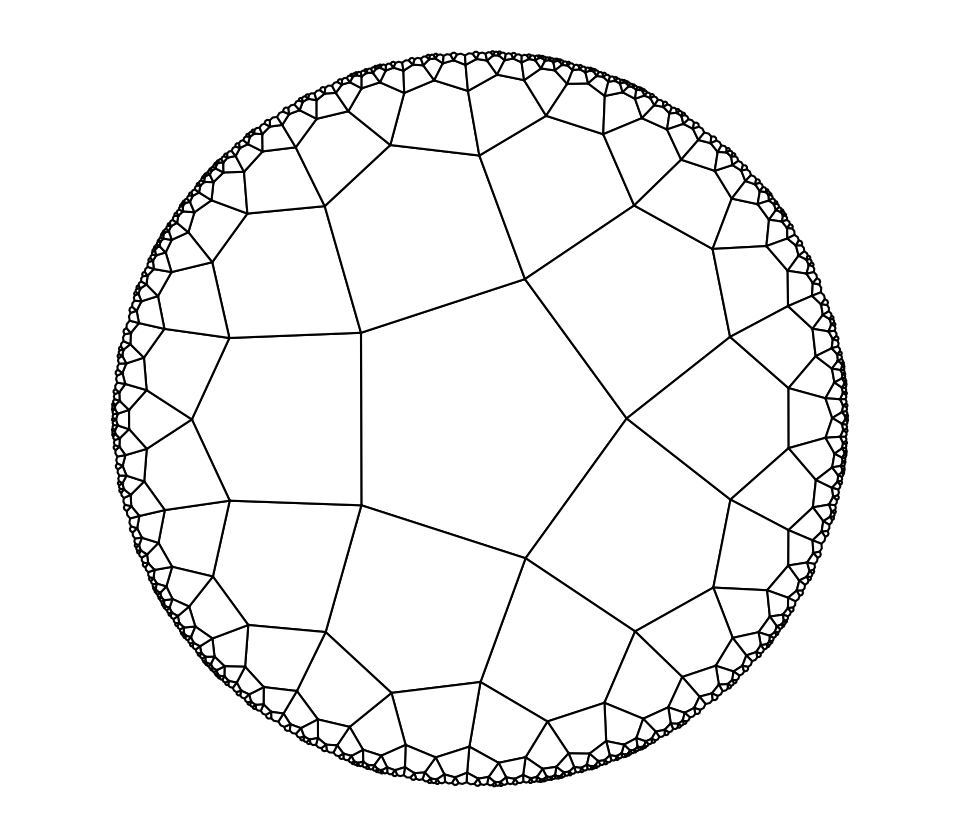

In [115]:
model.quick_plot()

In [71]:
model = md.FractonModel(5,4,5)
insidePols = insidePolygons(model)
bHoleRads = [0.01,0.31,0.71,0.82,0.89]

In [72]:
def geodesic(z1,z2,color,style,circle=False):
    if (np.round(np.real(z1)*np.imag(z2)-np.real(z2)*np.imag(z1),2))!= 0:
        a = (np.imag(z1)*(np.abs(z2)**2+1)-np.imag(z2)*(np.abs(z1)**2+1))/(np.real(z1)*np.imag(z2)-np.real(z2)*np.imag(z1))
        b = (np.real(z2)*(np.abs(z1)**2+1)-np.real(z1)*(np.abs(z2)**2+1))/(np.real(z1)*np.imag(z2)-np.real(z2)*np.imag(z1))
        r = np.sqrt((a**2+b**2)/4-1)
        if -np.pi/2<np.angle(z1) and np.angle(z1)<np.pi/2:
            theta0 = np.angle(z1+a/2+1j*b/2)
            theta1 = np.angle(z2+a/2+1j*b/2)
            if theta0 < 0:
                theta0 += 2*np.pi
            if theta1 < 0:
                theta1 += 2*np.pi
        else:
            theta0 = np.angle(z1+a/2+1j*b/2)
            theta1 = np.angle(z2+a/2+1j*b/2)
        theta = np.linspace(theta0,theta1,30)
        if circle:
            theta = np.linspace(0,2*np.pi,100)
        ax = plt.gca()
        zs = r*np.cos(theta)-a/2+1j*(r*np.sin(theta)-b/2)
        ax.plot(np.real(zs),np.imag(zs),style,color=color)


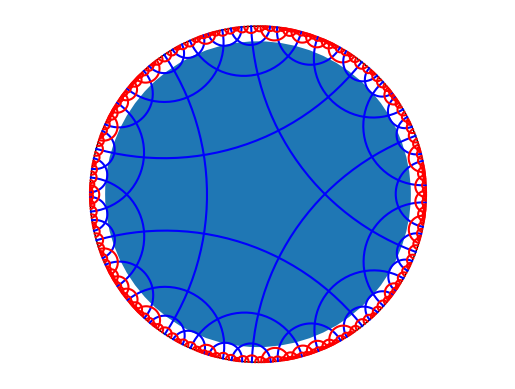

In [81]:
rads = [0.3036, 0.7075, 0.8197, 0.8892, 0.9035, 0.9201, 0.9376, 0.945, 0.9603, 0.9661, 0.9676, 0.9697, 0.9726, 0.9741, 0.9763, 0.9781, 0.9813, 0.9818, 0.9825, 0.984, 0.9844, 0.9867, 0.9871, 0.9885, 0.9896, 0.9914, 0.992]
rad = 0.91
for g in model.geodesicList:
    if g.distanceToOrigin > rad:
        geodesic(g.endpoints[0],g.endpoints[1],'red','-')
    else:
        #geodesic(g.endpoints[0],g.endpoints[1],'blue','-')
        
plt.axis('equal')
plt.axis('off')
circle = plt.Circle((0, 0), 1, fill = False)
ax = plt.gca()
ax.add_patch(circle)
circle2 = plt.Circle((0, 0), rad)
ax.add_patch(circle2)